In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
from tensorflow import keras

2025-10-21 15:25:18.859357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
audio_files = []
actors = os.listdir("archive")
for actor in actors:
    files = os.listdir("archive/"+actor)
    for file in files:
        audio_files.append("archive/"+actor+"/"+file)

print(audio_files)

['archive/Actor_15/03-01-06-02-01-02-15.wav', 'archive/Actor_15/03-01-08-02-01-01-15.wav', 'archive/Actor_15/03-01-04-01-02-02-15.wav', 'archive/Actor_15/03-01-06-02-02-02-15.wav', 'archive/Actor_15/03-01-03-01-01-01-15.wav', 'archive/Actor_15/03-01-05-01-02-01-15.wav', 'archive/Actor_15/03-01-07-01-02-01-15.wav', 'archive/Actor_15/03-01-07-01-01-02-15.wav', 'archive/Actor_15/03-01-04-02-02-02-15.wav', 'archive/Actor_15/03-01-07-02-01-01-15.wav', 'archive/Actor_15/03-01-03-02-01-01-15.wav', 'archive/Actor_15/03-01-01-01-01-01-15.wav', 'archive/Actor_15/03-01-08-01-02-02-15.wav', 'archive/Actor_15/03-01-05-02-02-02-15.wav', 'archive/Actor_15/03-01-06-02-02-01-15.wav', 'archive/Actor_15/03-01-08-01-01-01-15.wav', 'archive/Actor_15/03-01-04-01-01-02-15.wav', 'archive/Actor_15/03-01-06-02-01-01-15.wav', 'archive/Actor_15/03-01-03-01-02-01-15.wav', 'archive/Actor_15/03-01-06-01-01-01-15.wav', 'archive/Actor_15/03-01-03-02-02-01-15.wav', 'archive/Actor_15/03-01-02-01-01-01-15.wav', 'archive/

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

So we have to make the outputs for each audio, it means we have to select only the emotion for each audio.

In [5]:
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
Y = []
# We will iterate in a copy of audio_files to delete all the non-audio files
for audio in audio_files[:]:
    if not audio.endswith("wav"):
        audio_files.remove(audio)
    else:
        for i in range(0, 3):
            Y.append(int(audio.split("-")[2]) -1)

Y = np.array(Y)
Y = Y.astype(np.int32)

print(len(Y))
print(Y)

4320
[5 5 5 ... 3 3 3]


# Preparing my inputs data

In [6]:
def prepare_data(audio_path, sr=22050):
    audio_file, m = librosa.load(path=audio_path, sr=sr, duration=3.5)

    # We make sure our sound is 3.5 seconds before applying all the other functions on it
    if(len(audio_file) < int(sr*3.5)):
        audio_file = librosa.util.fix_length(audio_file, size=int(3.5*sr))
    
    mel_spec = librosa.feature.melspectrogram(y=audio_file, n_mels=256, sr=sr)
    mel_spectogram_db = librosa.power_to_db(mel_spec)
    # normalize the sample
    mel_spectogram_db = mel_spectogram_db.astype(np.float32)
    
    return mel_spectogram_db

# Augmentation Data

In [9]:
def add_noise(audio, noise_factor=0.005, sr=22050):

    audio_file, m = librosa.load(path=audio, sr=sr, duration=3.5)

    noise = np.random.randn(len(audio_file))
    augmented_audio = audio_file + noise_factor * noise

    if(len(augmented_audio) < int(sr*3.5)):
        augmented_audio = librosa.util.fix_length(augmented_audio, size=int(3.5*sr))
    
    mel_spec = librosa.feature.melspectrogram(y=augmented_audio, n_mels=256, sr=sr)
    mel_spectogram_db = librosa.power_to_db(mel_spec)
    # normalize the sample
    mel_spectogram_db = mel_spectogram_db.astype(np.float32)
    
    return mel_spectogram_db

def pitch_shift(audio, pitch_factor=2, sr=22050):

    audio_file, m = librosa.load(path=audio, sr=sr, duration=3.5)

    augmented_audio = librosa.effects.pitch_shift(audio_file, sr=sr, n_steps=pitch_factor)

    if(len(augmented_audio) < int(sr*3.5)):
        augmented_audio = librosa.util.fix_length(augmented_audio, size=int(3.5*sr))
    
    mel_spec = librosa.feature.melspectrogram(y=augmented_audio, n_mels=256, sr=sr)
    mel_spectogram_db = librosa.power_to_db(mel_spec)
    # normalize the sample
    mel_spectogram_db = mel_spectogram_db.astype(np.float32)
    
    return mel_spectogram_db



In [15]:
def prepare_data_set(audio_files):
    X = []

    for audio in audio_files:
        X.append(prepare_data(audio))
        X.append(add_noise(audio))
        X.append(pitch_shift(audio))

    return np.stack(X)

X = prepare_data_set(audio_files)
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# Shufffle the data

In [16]:
indices = np.arange(len(Y))
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

# Viewing some examples

80931


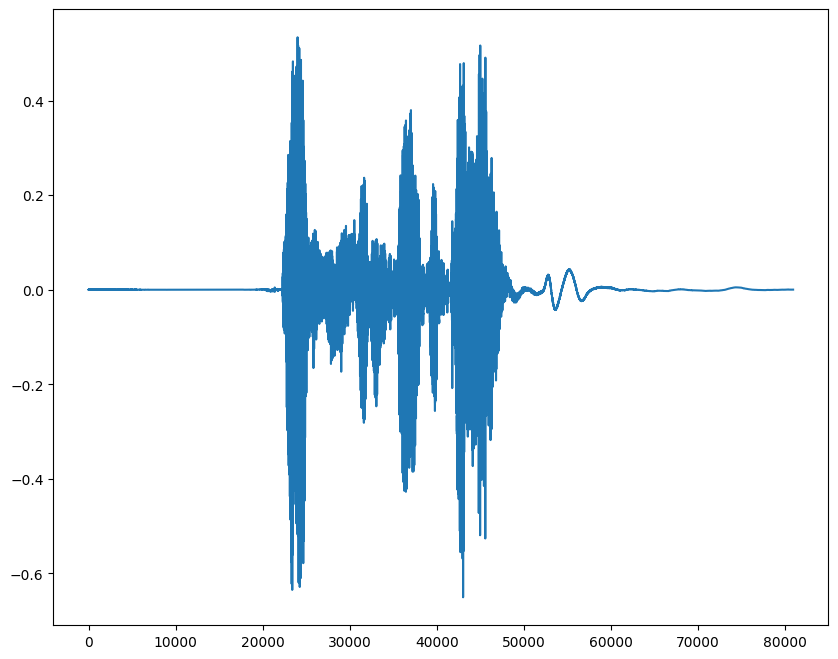

In [17]:
index = 90

audio_file, m = librosa.load(audio_files[index], sr=22050)
print(len(audio_file))

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(audio_file)
plt.show()

# Viewing spectrograms and melspectrograms

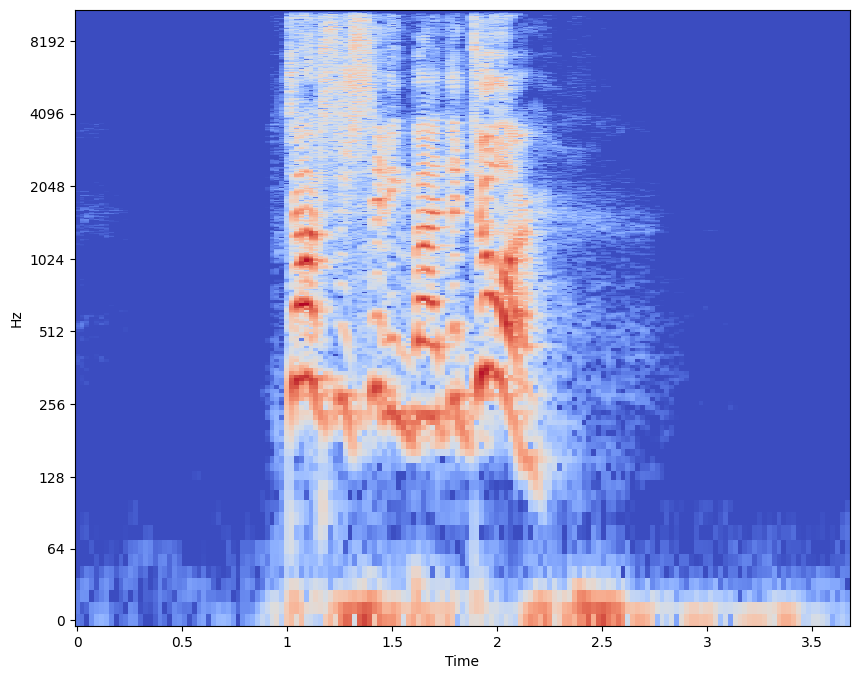

In [20]:
 # We apply short time fourier transform
audio_file_transformed = librosa.stft(audio_file)
# We make the spectogram
spectogram = np.abs(audio_file_transformed)
spectogram_db = librosa.amplitude_to_db(spectogram)
fig, ax = plt.subplots(figsize=(10, 8))
sp = librosa.display.specshow(spectogram_db, x_axis="time", y_axis="log", ax=ax)

[[-42.91535  -43.89583  -43.54335  ... -12.099876 -19.55067  -24.040836]
 [-43.74407  -39.528206 -39.0701   ... -27.549095 -30.915834 -30.257185]
 [-48.81742  -42.789307 -40.56942  ... -39.4411   -41.052784 -37.02645 ]
 ...
 [-53.066185 -53.066185 -53.066185 ... -53.066185 -53.066185 -53.066185]
 [-53.066185 -53.066185 -53.066185 ... -53.066185 -53.066185 -53.066185]
 [-53.066185 -53.066185 -53.066185 ... -53.066185 -53.066185 -53.066185]]


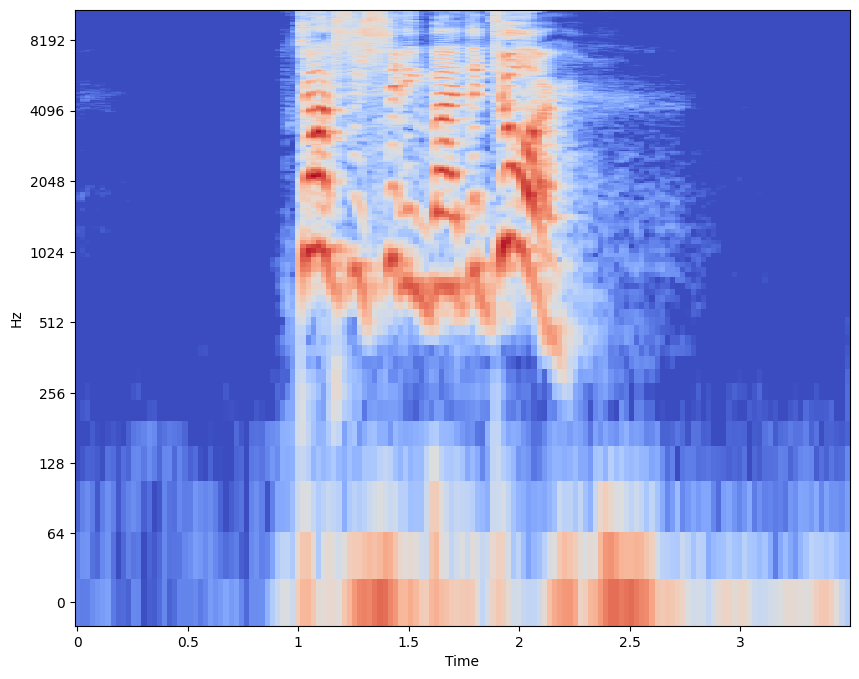

In [21]:
# using mel spectrogram:
my_example = prepare_data(audio_files[index])
print(my_example)
fig, ax = plt.subplots(figsize=(10, 8))
sp = librosa.display.specshow(my_example, x_axis="time", y_axis="log", ax=ax)

# Creating Model

In [22]:
model = keras.Sequential()

model.add(keras.layers.Input(X.shape[1:] + (1,)))

model.add(keras.layers.Conv2D(32 , kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64 , kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(8, activation='softmax'))
model.summary()

I0000 00:00:1761053682.559622   50121 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2600 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 149, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 127, 74, 32)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 74, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 74, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 72, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 62, 36, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 30, 17, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 14, 7, 256)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 7, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 7, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,03

 Total params: 1,204,072 (4.59 MB)

 Trainable params: 1,203,112 (4.59 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
train_size = int(0.8*len(X))

X_train = X[:train_size]
Y_train = Y[:train_size]

X_test = X[train_size:]
Y_test = Y[train_size:]

In [24]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

checkpoint = keras.callbacks.ModelCheckpoint(filepath="model.keras", monitor="val_accuracy", mode="max")

In [25]:
np.max(Y)

np.int32(7)

In [26]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, callbacks=checkpoint, validation_split=0.2)

test_scores = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

2025-10-21 15:35:07.212247: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 427380736 exceeds 10% of free system memory.
2025-10-21 15:35:07.625050: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 427380736 exceeds 10% of free system memory.


Epoch 1/100


2025-10-21 15:35:11.713481: I external/local_xla/xla/service/service.cc:163] XLA service 0x750064098530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-21 15:35:11.713512: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-21 15:35:11.819436: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-21 15:35:12.622725: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-21 15:35:13.562711: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,32,254,149]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,256,151]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__c

 1/44 ━━━━━━━━━━━━━━━━━━━━ 13:28 19s/step - loss: 2.1447 - sparse_categorical_accuracy: 0.0625

I0000 00:00:1761053726.631010   50747 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.9180 - sparse_categorical_accuracy: 0.2332

2025-10-21 15:35:33.075531: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[12,32,254,149]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,1,256,151]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-21 15:35:33.119914: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[12,64,125,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,32,127,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 1.9156 - sparse_categorical_accuracy: 0.2344

2025-10-21 15:35:41.920954: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,32,254,149]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,256,151]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-21 15:35:42.227233: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,125,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,127,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 488ms/step - loss: 1.8106 - sparse_categorical_accuracy: 0.2898 - val_loss: 2.0773 - val_sparse_categorical_accuracy: 0.1517
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 1.5620 - sparse_categorical_accuracy: 0.4088 - val_loss: 2.2748 - val_sparse_categorical_accuracy: 0.1344
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 1.4347 - sparse_categorical_accuracy: 0.4537 - val_loss: 2.5145 - val_sparse_categorical_accuracy: 0.1344
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 1.3257 - sparse_categorical_accuracy: 0.4960 - val_loss: 2.6173 - val_sparse_categorical_accuracy: 0.1344
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 1.1879 - sparse_categorical_accuracy: 0.5673 - val_loss: 2.8087 - val_sparse_categorical_accuracy: 0.1344
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 1.1055 - sparse_categorical_accuracy: 0.6017 - val_loss: 2.6050 - val_sparse_categorical_accuracy: 0.1460
Epoch 7/1

2025-10-21 15:45:46.169694: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,254,149]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,256,151]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-21 15:45:46.282114: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,125,72]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,127,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

27/27 - 3s - 106ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.8623
Test loss: 0.5620549321174622
Test accuracy: 0.8622685074806213


In [27]:
test_scores = model.evaluate(X_train, Y_train, verbose=2)
print(test_scores)

2025-10-21 15:47:22.742205: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 534380544 exceeds 10% of free system memory.
2025-10-21 15:47:23.297598: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 534380544 exceeds 10% of free system memory.


108/108 - 2s - 19ms/step - loss: 0.0930 - sparse_categorical_accuracy: 0.9774
[0.09296304732561111, 0.9774305820465088]


In [28]:
test_scores = model.evaluate(X_test, Y_test, verbose=2)
print(test_scores)

27/27 - 1s - 22ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.8623
[0.5620549321174622, 0.8622685074806213]
